In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

MedQA

GPT3.5

In [35]:
df_vanilla = pd.read_parquet("results/medqa_gpt-3.5-turbo_vanilla_base_all_00:18:36.parquet")
df_cot = pd.read_parquet("results/medqa_gpt-3.5-turbo_cot_base_all_02:09:33.parquet")
df_atypical_scenario = pd.read_parquet("results/medqa_gpt-3.5-turbo_atypical-situation_base_all_21:36:22.parquet")
df_atypical_presentations = pd.read_parquet("results/medqa_gpt-3.5-turbo_atypical_base_all_01:18:19.parquet")
df_consistency = pd.read_parquet("results/medqa_gpt-3.5-turbo_vanilla_consistency_all_23:56:41.parquet")
df_average = pd.read_parquet("results/medqa_gpt-3.5-turbo_vanilla_average_all_08:02:00.parquet")

In [36]:
df_consistency['Binary Ground Truth'] = (df_consistency['Ground Truth Probability'] >= 0.5).astype(int)
df_average['Binary Ground Truth'] = (df_average['Ground Truth Probability'] >= 0.5).astype(int)


In [37]:
def compute_atypical_scores(row):
    confidence_score = row['All Vanilla Confidence Scores'][0]
    calibrated_confidence = row['All Confidence Scores'][0]
    atypical_scores = np.log(calibrated_confidence / confidence_score) + 1
    return atypical_scores

In [38]:
df_vanilla['Atypicality'] = df_vanilla.apply(compute_atypical_scores, axis=1)
df_cot['Atypicality'] = df_cot.apply(compute_atypical_scores, axis=1)
df_atypical_scenario['Atypicality'] = df_atypical_scenario.apply(compute_atypical_scores, axis=1)
df_atypical_presentations['Atypicality'] = df_atypical_presentations.apply(compute_atypical_scores, axis=1)
df_consistency['Atypicality'] = df_consistency.apply(compute_atypical_scores, axis=1)
df_average['Atypicality'] = df_average.apply(compute_atypical_scores, axis=1)

In [52]:
prob_true, prob_pred = calibration_curve(df_vanilla['Ground Truth Probability'], df_vanilla['All Vanilla Confidence Scores'].apply(lambda x: x[0]/100), n_bins=10)

In [53]:
prob_true_cot, prob_pred_cot = calibration_curve(df_cot['Ground Truth Probability'], df_cot['All Confidence Scores'].apply(lambda x: x[0]/100), n_bins=10)
prob_true_atypical_scenario, prob_pred_atypical_scenario = calibration_curve(df_atypical_scenario['Ground Truth Probability'], df_atypical_scenario['All Confidence Scores'].apply(lambda x: x[0]/100), n_bins=10)
prob_true_atypical_presentations, prob_pred_presentations = calibration_curve(df_atypical_presentations['Ground Truth Probability'], df_atypical_presentations['All Confidence Scores'].apply(lambda x: x[0]/100), n_bins=10)
prob_true_consistency, prob_pred_consistency = calibration_curve(df_consistency['Binary Ground Truth'], df_consistency['Consistency Confidence'], n_bins=10)
prob_true_average, prob_pred_average = calibration_curve(df_average['Binary Ground Truth'], df_average['Average Confidence'], n_bins=10)                   

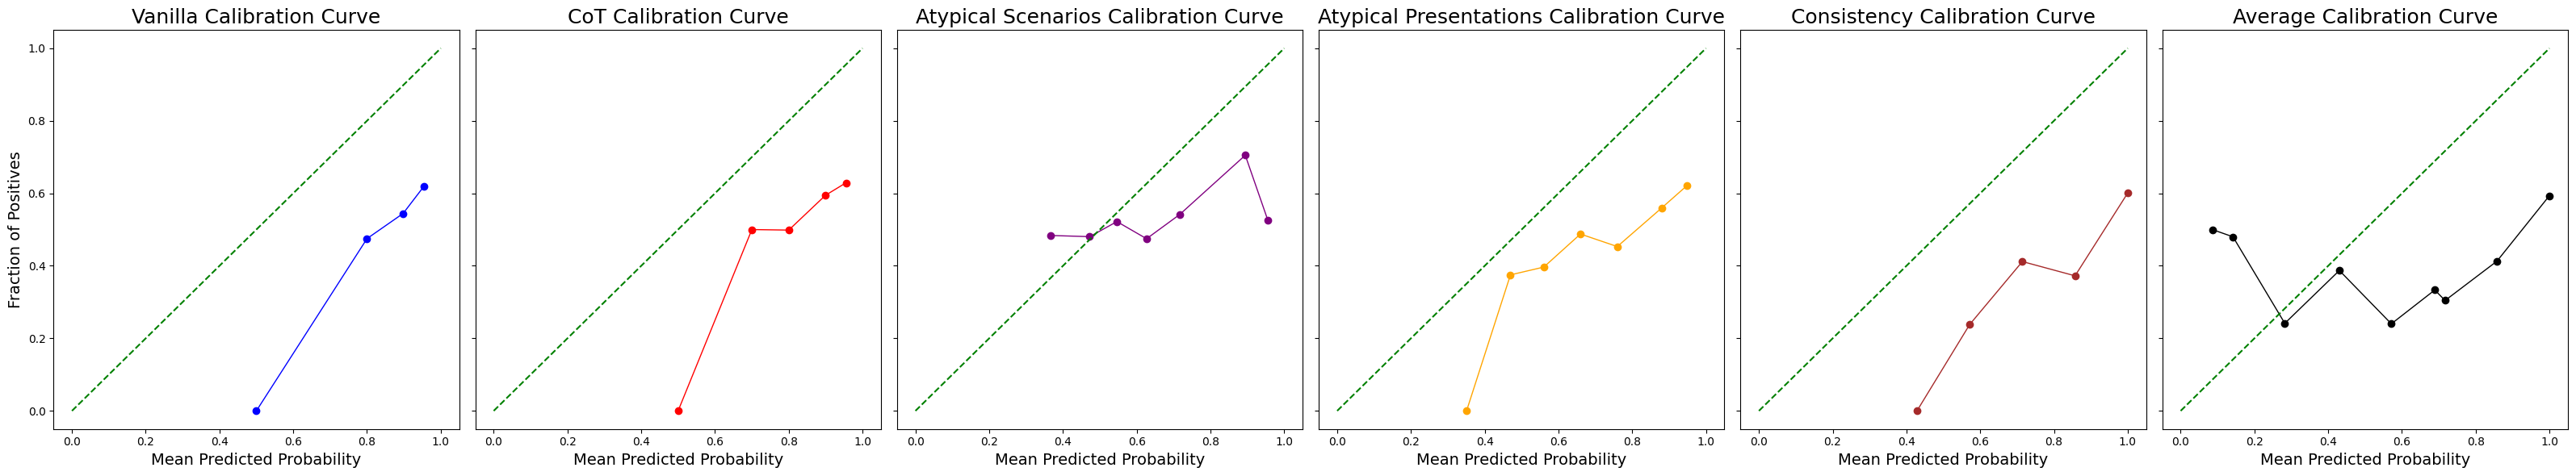

In [135]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 6, figsize=(32, 6), sharey=True)

# Define colors for each plot
colors = ['blue', 'red', 'purple', 'orange', 'brown', 'black']

# Plot each calibration curve in its own subplot with specified colors
axs[0].plot(prob_pred, prob_true, marker='o', linewidth=1, color=colors[0], label='Vanilla')
axs[0].plot([0, 1], [0, 1], linestyle='--', color='green', label='Perfect Calibration')
axs[0].set_title('Vanilla Calibration Curve', fontsize=18)
axs[0].set_xlabel('Mean Predicted Probability', fontsize=14)
axs[0].set_ylabel('Fraction of Positives', fontsize=14)

axs[1].plot(prob_pred_cot, prob_true_cot, marker='o', linewidth=1, color=colors[1], label='CoT')
axs[1].plot([0, 1], [0, 1], linestyle='--', color='green', label='Perfect Calibration')
axs[1].set_title('CoT Calibration Curve', fontsize=18)
axs[1].set_xlabel('Mean Predicted Probability', fontsize=14)

axs[2].plot(prob_pred_atypical_scenario, prob_true_atypical_scenario, marker='o', linewidth=1, color=colors[2], label='Atypical Scenarios')
axs[2].plot([0, 1], [0, 1], linestyle='--', color='green', label='Perfect Calibration')
axs[2].set_title('Atypical Scenarios Calibration Curve', fontsize=18)
axs[2].set_xlabel('Mean Predicted Probability', fontsize=14)

axs[3].plot(prob_pred_presentations, prob_true_atypical_presentations, marker='o', linewidth=1, color=colors[3], label='Atypical Presentations')
axs[3].plot([0, 1], [0, 1], linestyle='--', color='green', label='Perfect Calibration')
axs[3].set_title('Atypical Presentations Calibration Curve', fontsize=18)
axs[3].set_xlabel('Mean Predicted Probability', fontsize=14)

axs[4].plot(prob_pred_consistency, prob_true_consistency, marker='o', linewidth=1, color=colors[4], label='Consistency')
axs[4].plot([0, 1], [0, 1], linestyle='--', color='green', label='Perfect Calibration')
axs[4].set_title('Consistency Calibration Curve', fontsize=18)
axs[4].set_xlabel('Mean Predicted Probability', fontsize=14)

axs[5].plot(prob_pred_average, prob_true_average, marker='o', linewidth=1, color=colors[5], label='Average')
axs[5].plot([0, 1], [0, 1], linestyle='--', color='green', label='Perfect Calibration')
axs[5].set_title('Average Calibration Curve', fontsize=18)
axs[5].set_xlabel('Mean Predicted Probability', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.savefig('graphs/calibration_curves.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [79]:
# Bin the atypicality scores
num_bins = 7

bins_scenario = np.linspace(df_atypical_scenario['Atypicality'].min(), df_atypical_scenario['Atypicality'].max(), num_bins + 1)
df_atypical_scenario['atypicality_bin'] = pd.cut(df_atypical_scenario['Atypicality'], bins_scenario, include_lowest=True)

bins_presentations = np.linspace(df_atypical_presentations['Atypicality'].min(), df_atypical_presentations['Atypicality'].max(), num_bins + 1)
df_atypical_presentations['atypicality_bin'] = pd.cut(df_atypical_presentations['Atypicality'], bins_presentations, include_lowest=True)

In [95]:
def calculate_ece(df, bin_column, prob_column, true_label_column):
    ece = []
    bins = df[bin_column].unique()
    for bin in bins:
        bin_data = df[df[bin_column] == bin]
        bin_prob = bin_data[prob_column]
        bin_true = bin_data[true_label_column]
        bin_ece = np.abs(bin_prob.mean() - bin_true.mean())
        ece.append(bin_ece)
    return pd.Series(ece, index=bins)

In [99]:
df_atypical_scenario['Calibrated Confidence'] = df_atypical_scenario['All Confidence Scores'].apply(lambda x: x[0]/100)
df_atypical_presentations['Calibrated Confidence'] = df_atypical_presentations['All Confidence Scores'].apply(lambda x: x[0]/100)

In [100]:
# Calculate ECE for each bin
ece_scenario = calculate_ece(df_atypical_scenario, 'atypicality_bin', 'Calibrated Confidence', 'Ground Truth Probability')
ece_presentations = calculate_ece(df_atypical_presentations, 'atypicality_bin', 'Calibrated Confidence', 'Ground Truth Probability')

/tmp/ipykernel_9397/1505992573.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_scenario = df_atypical_scenario.groupby('atypicality_bin')['accuracy'].mean()
/tmp/ipykernel_9397/1505992573.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_presentations = df_atypical_presentations.groupby('atypicality_bin')['accuracy'].mean()


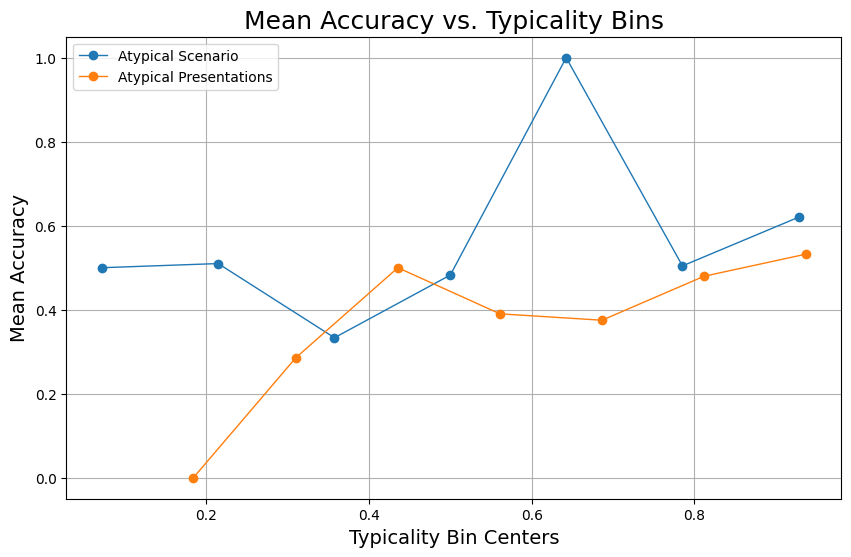

In [143]:
# Calculate mean accuracy within each atypicality bin
df_atypical_scenario['accuracy'] = df_atypical_scenario['Ground Truth Probability']
df_atypical_presentations['accuracy'] = df_atypical_presentations['Ground Truth Probability']

mean_accuracy_scenario = df_atypical_scenario.groupby('atypicality_bin')['accuracy'].mean()
mean_accuracy_presentations = df_atypical_presentations.groupby('atypicality_bin')['accuracy'].mean()

# Get the bin centers
bin_centers_scenario = [interval.mid for interval in mean_accuracy_scenario.index]
bin_centers_presentations = [interval.mid for interval in mean_accuracy_presentations.index]

# Plot mean accuracy against atypicality bins
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_scenario, mean_accuracy_scenario.values, marker='o', linewidth=1, label="Atypical Scenario")
plt.plot(bin_centers_presentations, mean_accuracy_presentations.values, marker='o', linewidth=1, label="Atypical Presentations")
plt.xlabel('Typicality Bin Centers', fontsize=14)
plt.ylabel('Mean Accuracy', fontsize=14)
plt.title('Mean Accuracy vs. Typicality Bins', fontsize=18)
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig('graphs/acc_vs_atypicality.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

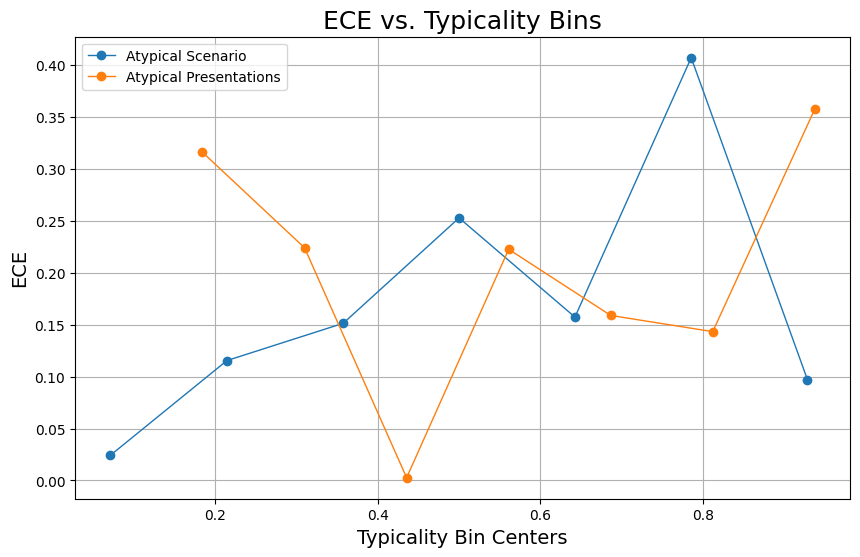

In [144]:
# Plot ECE against atypicality bins
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_scenario, ece_scenario.values, marker='o', linewidth=1, label="Atypical Scenario")
plt.plot(bin_centers_presentations, ece_presentations.values, marker='o', linewidth=1, label="Atypical Presentations")
plt.xlabel('Typicality Bin Centers', fontsize=14)
plt.ylabel('ECE', fontsize=14)
plt.title('ECE vs. Typicality Bins', fontsize=18)
plt.grid(True)
plt.legend()
plt.savefig('graphs/ece_vs_atypicality.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

In [89]:
df_atypical_scenario['difficulty'] = df_atypical_scenario['Difficulty Score'].apply(lambda x: x[0])
df_atypical_presentations['difficulty'] = df_atypical_presentations['Difficulty Score'].apply(lambda x: x[0])

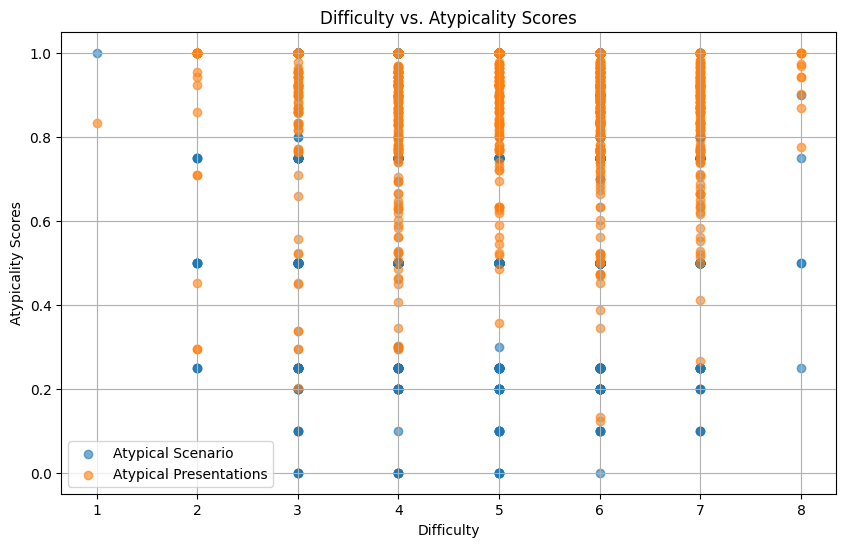

In [94]:
# Plot difficulty against atypicality scores
plt.figure(figsize=(10, 6))
plt.scatter(df_atypical_scenario['difficulty'], df_atypical_scenario['Atypicality'], alpha=0.6, label="Atypical Scenario")
plt.scatter(df_atypical_presentations['difficulty'], df_atypical_presentations['Atypicality'], alpha=0.6, label="Atypical Presentations")
plt.xlabel('Difficulty')
plt.ylabel('Atypicality Scores')
plt.title('Difficulty vs. Atypicality Scores')
plt.grid(True)
plt.legend()
plt.savefig('graphs/difficulty_vs_atypicality.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

In [137]:
# Define custom color palette
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']

# Data from the table reformatted for the new requirement
data = {
    'Datasets': ['MedQA', 'MedQA', 'MedQA', 'MedQA', 'MedQA', 'MedQA',
                 'MedMCQA', 'MedMCQA', 'MedMCQA', 'MedMCQA', 'MedMCQA', 'MedMCQA',
                 'PubMedQA', 'PubMedQA', 'PubMedQA', 'PubMedQA', 'PubMedQA', 'PubMedQA'],
    'Methods': ['Vanilla', 'CoT', 'Atypical scenario', 'Atypical presentations', 'Consistency (k=3)', 'Average (k=3)',
                'Vanilla', 'CoT', 'Atypical scenario', 'Atypical presentations', 'Consistency (k=3)', 'Average (k=3)',
                'Vanilla', 'CoT', 'Atypical scenario', 'Atypical presentations', 'Consistency (k=3)', 'Average (k=3)'],
    'ECE': [0.351, 0.318, 0.084, 0.283, 0.408, 0.398,  # MedQA
            0.323, 0.357, 0.128, 0.152, 0.350, 0.350,  # MedMCQA
            0.251, 0.275, 0.115, 0.129, 0.335, 0.346]  # PubMedQA
}

df = pd.DataFrame(data)

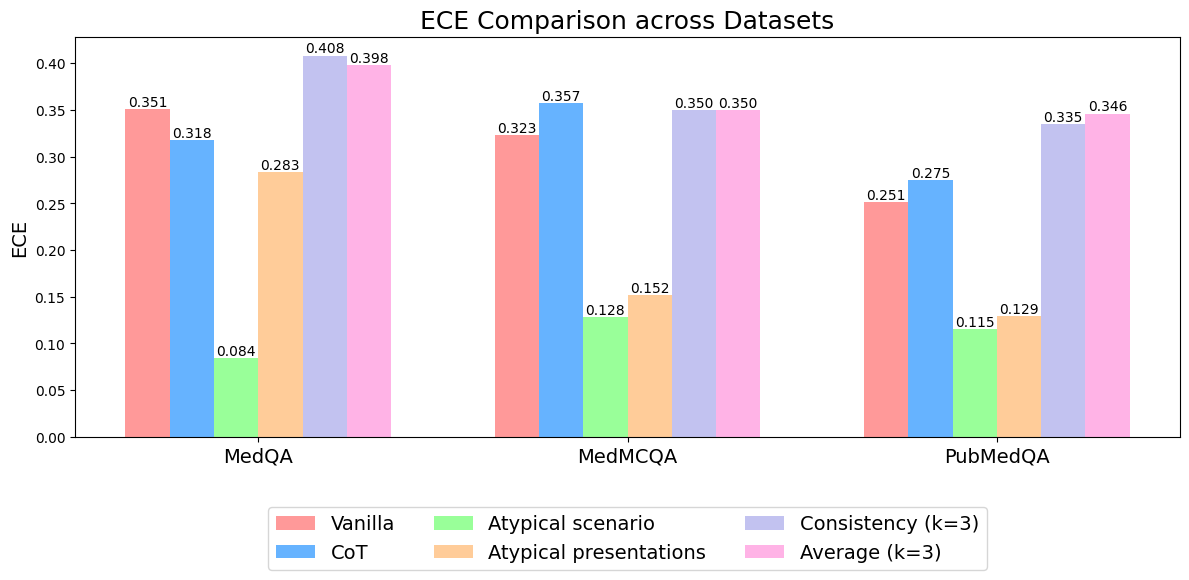

In [141]:
# Adjusting the legend position to avoid overlapping with the bars
bar_width = 0.12
datasets = ['MedQA', 'MedMCQA', 'PubMedQA']
index = range(len(datasets))
# Adjusting the legend position to avoid overlapping with the x-axis title
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each method per dataset
for i, method in enumerate(df['Methods'].unique()):
    bar = plt.bar([j + i*bar_width for j in index], df[df['Methods'] == method]['ECE'], bar_width, label=method, color=colors[i])
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.3f}', ha='center', va='bottom')

# plt.xlabel('Datasets')
plt.ylabel('ECE', fontsize=14)
plt.title('ECE Comparison across Datasets', fontsize=18)
plt.xticks([r + 2.5*bar_width for r in index], datasets, fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=14)  # Move legend further down

plt.tight_layout()
plt.savefig('graphs/ece_per_datasets.png', format='png', dpi=200, bbox_inches='tight')
plt.show()


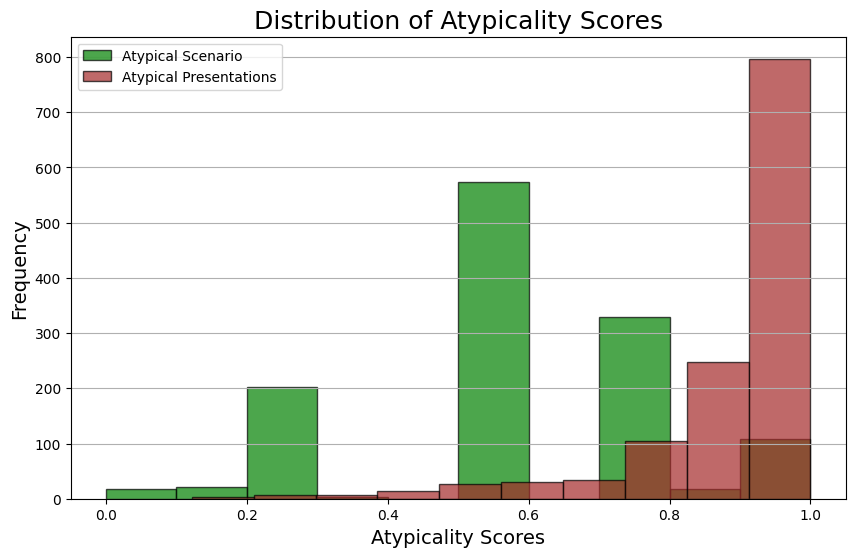

In [142]:
# Plotting the distribution of atypicality scores
plt.figure(figsize=(10, 6))
plt.hist(df_atypical_scenario['Atypicality'], bins=10, color='green', edgecolor='black', alpha=0.7, label="Atypical Scenario")
plt.hist(df_atypical_presentations['Atypicality'], bins=10, color='brown', edgecolor='black', alpha=0.7, label="Atypical Presentations")
plt.xlabel('Atypicality Scores', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Atypicality Scores', fontsize=18)
plt.grid(axis='y')
plt.legend()
plt.savefig('graphs/atypicality_distribution.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

In [145]:
df_atypical_presentations.head()

,Questions,Difficulty Score,Mean Difficulty Score,Correct Answers,Majority Predicted Answer,All Predicted Answers,Final Prediction,Consistency Confidence,Average Vanilla Confidence,Average Confidence,All Vanilla Confidence Scores,All Confidence Scores,Ground Truth Probability,Atypicality,atypicality_bin,accuracy,difficulty,Calibrated Confidence
0,A 21-year-old sexually active male complains o...,[5],5.0,D,D,[D],D,1.0,1.0,1.0,[80],[80.0],1.0,1.000000,"(0.875, 1.0]",1.0,5,0.800000
1,A 5-year-old girl is brought to the emergency ...,[6],6.0,A,A,[A],A,1.0,1.0,1.0,[80],[77.47200894938749],1.0,0.967890,"(0.875, 1.0]",1.0,6,0.774720
2,A 40-year-old woman presents with difficulty f...,[3],3.0,E,C,[C],C,1.0,1.0,1.0,[90],[86.28405589149901],0.0,0.957835,"(0.875, 1.0]",0.0,3,0.862841
3,A 37-year-old female with a history of type II...,[4],4.0,C,C,[C],C,1.0,1.0,1.0,[90],[82.03682819057057],1.0,0.907359,"(0.875, 1.0]",1.0,4,0.820368
4,A 19-year-old boy presents with confusion and ...,[4],4.0,A,C,[C],C,1.0,1.0,1.0,[90],[84.94110848201957],0.0,0.942149,"(0.875, 1.0]",0.0,4,0.849411


In [146]:
df_atypical_presentations['vanilla confidence'] = df_atypical_presentations['All Vanilla Confidence Scores'].apply(lambda x: x[0])
df_atypical_scenario['vanilla confidence'] = df_atypical_scenario['All Vanilla Confidence Scores'].apply(lambda x: x[0])

In [159]:
df_atypical_presentations['confidence_bin'] = pd.cut(df_atypical_presentations['vanilla confidence'], bins=4)
df_atypical_scenario['confidence_bin'] = pd.cut(df_atypical_scenario['vanilla confidence'], bins=4)

# Calculating mean atypicality for each bin
mean_atypicality_presentations = df_atypical_presentations.groupby('confidence_bin')['Atypicality'].mean()
mean_atypivality_scenario = df_atypical_scenario.groupby('confidence_bin')['Atypicality'].mean()

/tmp/ipykernel_9397/2068297462.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_atypicality_presentations = df_atypical_presentations.groupby('confidence_bin')['Atypicality'].mean()
/tmp/ipykernel_9397/2068297462.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_atypivality_scenario = df_atypical_scenario.groupby('confidence_bin')['Atypicality'].mean()


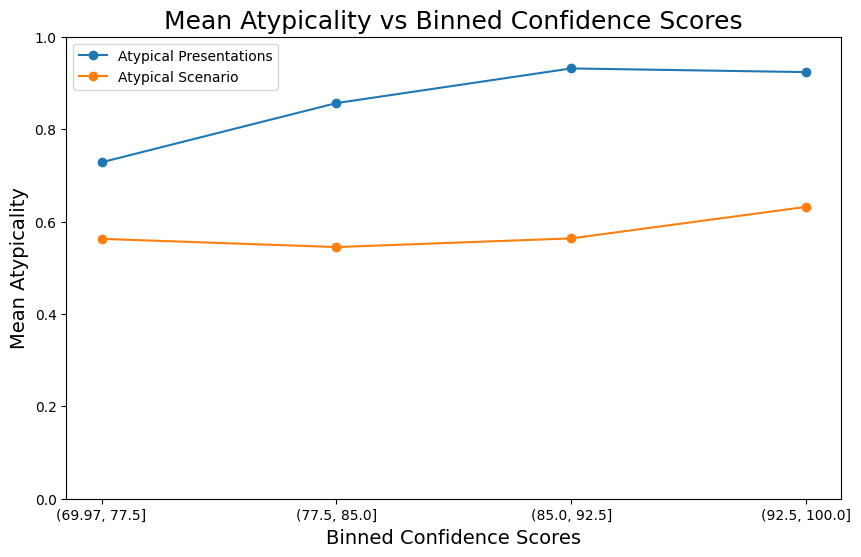

In [166]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(mean_atypicality_presentations.index.astype(str), mean_atypicality_presentations.values, marker='o', linestyle='-', label="Atypical Presentations")
plt.plot(mean_atypivality_scenario.index.astype(str), mean_atypivality_scenario.values, marker='o', linestyle='-', label='Atypical Scenario')
plt.xlabel('Binned Confidence Scores', fontsize=14)
plt.ylabel('Mean Atypicality', fontsize=14)
plt.title('Mean Atypicality vs Binned Confidence Scores', fontsize=18)
plt.ylim(0, 1)
plt.legend()
plt.savefig('graphs/atypicality_vs_confidence.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

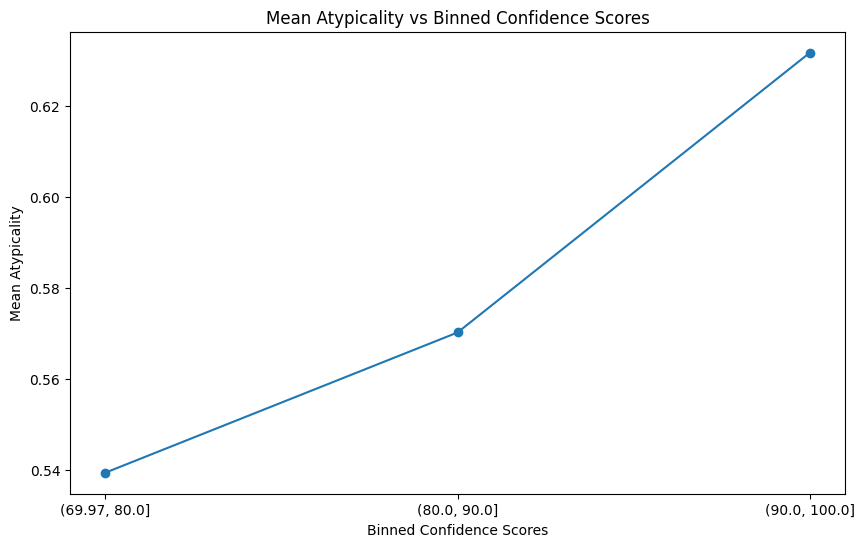

In [155]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(mean_atypivality_scenario.index.astype(str), mean_atypivality_scenario.values, marker='o', linestyle='-')
plt.xlabel('Binned Confidence Scores')
plt.ylabel('Mean Atypicality')
plt.title('Mean Atypicality vs Binned Confidence Scores')
plt.show()